################## ANIME.CSV ANALYSIS ################## 

Number of columns in anime.csv:  7
Index(['anime_id', 'name', 'genre', 'type', 'episodes', 'rating', 'members'], dtype='object')

Number of rows in anime.csv:  12294

Number of duplicate anime_id in anime.csv:  0

Number of unique genre: 43
Unique genre: ['Drama' 'Romance' 'School' 'Supernatural' 'Action' 'Adventure' 'Fantasy'
 'Magic' 'Military' 'Shounen' 'Comedy' 'Historical' 'Parody' 'Samurai'
 'Sci-Fi' 'Thriller' 'Sports' 'Super Power' 'Space' 'Slice of Life'
 'Mecha' 'Music' 'Mystery' 'Seinen' 'Martial Arts' 'Vampire' 'Shoujo'
 'Horror' 'Police' 'Psychological' 'Demons' 'Ecchi' 'Josei' 'Shounen Ai'
 'Game' 'Dementia' 'Harem' 'Cars' 'Kids' 'Shoujo Ai' 'Hentai' 'Yaoi'
 'Yuri']

Number of unique type: 6
Unique type: ['Movie' 'TV' 'OVA' 'Special' 'Music' 'ONA']

Number of rows with missing values in anime.csv:  277

Rows with missing values in anime.csv:
       anime_id                                       name genre     type

/var/folders/cp/qnxjs_1j4t16tppddxshp8b80000gn/T/ipykernel_11675/1267569389.py:81: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


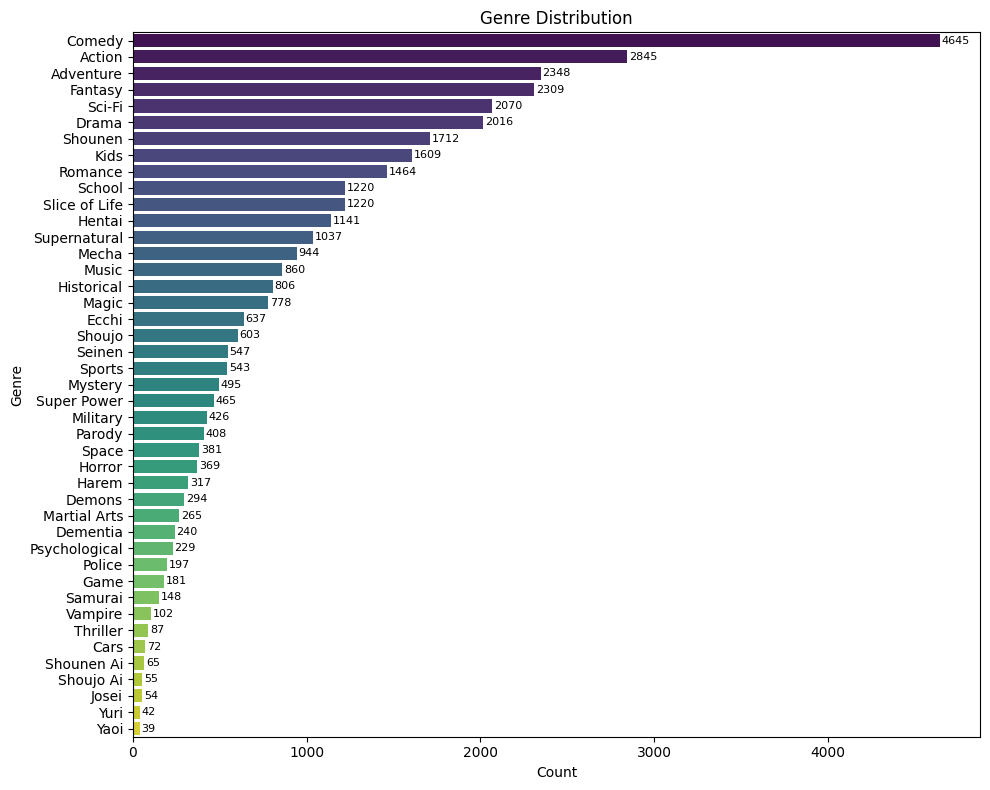

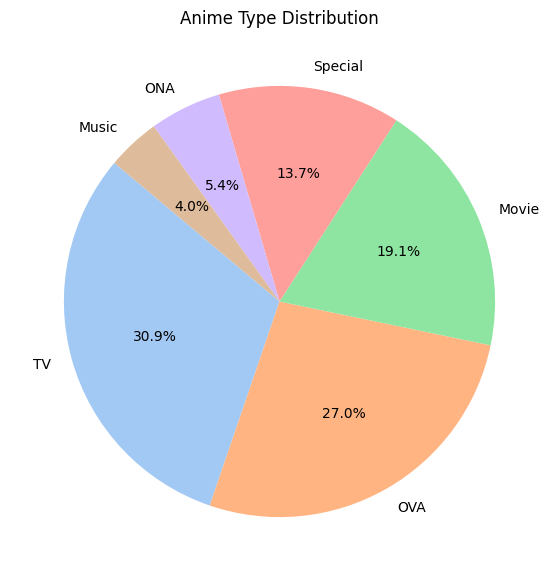

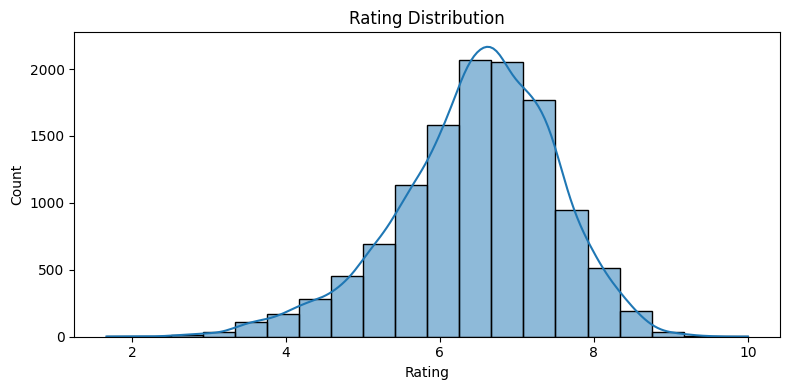


################## RATING.CSV ANALYSIS ################## 

Number of columns in rating.csv:  3
Index(['user_id', 'anime_id', 'rating'], dtype='object')

Number of rows in rating.csv:  7813737

Number of duplicate anime_id in rating.csv:  7802537

Number of unique users in rating.csv:  73515

Number of rows with missing values in rating.csv:  0

Number of rows with -1 as rating in rating.csv:  1476496

Standard descriptive statistics for rating.csv:
             user_id      anime_id        rating
count  7.813737e+06  7.813737e+06  7.813737e+06
mean   3.672796e+04  8.909072e+03  6.144030e+00
std    2.099795e+04  8.883950e+03  3.727800e+00
min    1.000000e+00  1.000000e+00 -1.000000e+00
25%    1.897400e+04  1.240000e+03  6.000000e+00
50%    3.679100e+04  6.213000e+03  7.000000e+00
75%    5.475700e+04  1.409300e+04  9.000000e+00
max    7.351600e+04  3.451900e+04  1.000000e+01


ValueError: If using all scalar values, you must pass an index

<Figure size 1000x600 with 0 Axes>

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

############### Helper functions ###############

def count_unique_elements(df: pd.DataFrame, col: str):
    col_series = df[col].dropna()
    all_different_value_col = col_series.str.split(',').explode().str.strip() # Split each genre string by comma and flatten the list
    unique_value_col = all_different_value_col.unique()
    print(f"\nNumber of unique {col}:", len(unique_value_col))
    print(f"Unique {col}:", unique_value_col)
    return unique_value_col, len(unique_value_col)

############### TASK 1 (Explore and describe the data) ###############

# --------- Analyze anime.csv --------- 
print("################## ANIME.CSV ANALYSIS ################## ")
# 1. Load the dataset
anime_df = pd.read_csv('data/anime.csv')
# 2. Basic checks
print("\nNumber of columns in anime.csv: ", len(anime_df.columns))
print(anime_df.columns)
print("\nNumber of rows in anime.csv: ", len(anime_df))
# check if anime_id contains duplicates
anime_id_duplicates = anime_df['anime_id'].duplicated().sum()
print("\nNumber of duplicate anime_id in anime.csv: ", anime_id_duplicates)
# check unique genres
unique_genres, unique_genres_count = count_unique_elements(anime_df, 'genre')
# check unique type
unique_type, unique_type_count = count_unique_elements(anime_df, 'type')
# check rows that contain missing values, if same row has multiple missing values count only once
missing_values = anime_df.isnull().sum(axis=1) > 0
missing_values_count = missing_values.sum()
print("\nNumber of rows with missing values in anime.csv: ", missing_values_count)
print("\nRows with missing values in anime.csv:\n", anime_df[missing_values].head(5))
# check col with most missing values
missing_values_count = anime_df.isnull().sum()
missing_values_count = missing_values_count[missing_values_count > 0]
missing_values_count = missing_values_count.sort_values(ascending=False)
print("\nColumns with missing values in anime.csv:\n", missing_values_count)
# check cols with 'Unknown' as value
unknown_values_count = anime_df.isin(['Unknown']).sum()
unknown_values_count = unknown_values_count[unknown_values_count > 0]
unknown_values_count = unknown_values_count.sort_values(ascending=False)
print("\nColumns with 'Unknown' as value in anime.csv:\n", unknown_values_count)
# check anime with most episodes, ignore the ones with 'Unknown' as value
anime_df['episodes'] = pd.to_numeric(anime_df['episodes'], errors='coerce')
most_episodes = anime_df[anime_df['episodes'] != 'Unknown'].sort_values(by='episodes', ascending=False).head(3)
print("\nTop 3 anime with most episodes:\n", most_episodes)
# chec anime with least episodes, ignore the ones with 'Unknwon' as value and 1 episode (film)
least_episodes = anime_df[anime_df['episodes'] != 'Unknown']
least_episodes = least_episodes[least_episodes['episodes'] != 1]
least_episodes = least_episodes.sort_values(by='episodes', ascending=True).head(3)
print("\nTop 3 anime with least episodes:\n", least_episodes)
# check anime with most members
anime_df['members'] = pd.to_numeric(anime_df['members'], errors='coerce')
most_members = anime_df.sort_values(by='members', ascending=False).head(3)
print("\nTop 3 anime with most members:\n", most_members)
# check anime with least members
least_members = anime_df[anime_df['members'] != 'Unknown']
least_members = least_members[least_members['members'] != 0]
least_members = least_members.sort_values(by='members', ascending=True).head(3)
print("\nTop 3 anime with least members:\n", least_members)
# check anime with highest rating
anime_df['rating'] = pd.to_numeric(anime_df['rating'], errors='coerce')
highest_rating = anime_df.sort_values(by='rating', ascending=False).head(3)
print("\nTop 3 anime with highest rating:\n", highest_rating)
# check anime with lowest rating
lowest_rating = anime_df[anime_df['rating'] != 0]
lowest_rating = lowest_rating.sort_values(by='rating', ascending=True).head(3)
print("\nTop 3 anime with lowest rating:\n", lowest_rating)
# 3. Standard descriptive statistics
print("\nStandard descriptive statistics for anime.csv:\n", anime_df.describe())
# 4. Variable visualization
# Genre distribution
genre_counts = anime_df['genre'].str.split(',').explode().str.strip().value_counts()

plt.figure(figsize=(10, 8))
sns.barplot(
    y=genre_counts.index,
    x=genre_counts.values,
    palette='viridis'
)
plt.xlabel('Count')
plt.ylabel('Genre')
plt.title('Genre Distribution')
for i, v in enumerate(genre_counts.values):
    plt.text(v + 10, i, str(v), color='black', va='center', fontsize=8)
plt.tight_layout()
plt.savefig('images/genre_distribution_improved.png')
plt.show()
# Type distribution
type_counts = anime_df['type'].value_counts()

plt.figure(figsize=(7, 7))
plt.pie(
    type_counts,
    labels=type_counts.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=sns.color_palette('pastel')
)
plt.title('Anime Type Distribution')
plt.savefig('images/type_distribution_improved.png')
plt.show()
# Rating distribution
plt.figure(figsize=(8, 4))
sns.histplot(anime_df['rating'].dropna(), bins=20, kde=True)
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Rating Distribution')
plt.tight_layout()
plt.savefig('images/rating_distribution.png')
plt.show()

# --------- Analyze rating.csv --------- 
print("\n################## RATING.CSV ANALYSIS ################## ")
# 1. Load the dataset
rating_df = pd.read_csv('data/rating.csv') 
# 2. Basic checks
print("\nNumber of columns in rating.csv: ", len(rating_df.columns))
print(rating_df.columns)
print("\nNumber of rows in rating.csv: ", len(rating_df))
# check if anime_id contains duplicates
rating_anime_id_duplicates = rating_df['anime_id'].duplicated().sum()
print("\nNumber of duplicate anime_id in rating.csv: ", rating_anime_id_duplicates)
#  check unique users 
unique_userd = rating_df['user_id'].nunique()
print("\nNumber of unique users in rating.csv: ", unique_userd)
# check rows that contain missing values, if same row has multiple missing values count only once
missing_values = rating_df.isnull().sum(axis=1) > 0
missing_values_count = missing_values.sum()
print("\nNumber of rows with missing values in rating.csv: ", missing_values_count)
# check number of rows with -1 as rating
rating_df['rating'] = pd.to_numeric(rating_df['rating'], errors='coerce')
rating_minus_1 = rating_df[rating_df['rating'] == -1]
rating_minus_1_count = rating_minus_1.shape[0]
print("\nNumber of rows with -1 as rating in rating.csv: ", rating_minus_1_count)
# 3. Standard descriptive statistics
print("\nStandard descriptive statistics for rating.csv:\n", rating_df.describe())
# 4. Variable visualization
plt.figure(figsize=(10, 6))
sns.countplot(x=rating_df, palette='coolwarm')
plt.title('Distribution of Valid Ratings (Excluding -1)')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig('images/rating_distribution.png')
plt.show()